In [1]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

fatal: destination path 'Neutron_Reflect' already exists and is not an empty directory.


In [2]:
cd Neutron_Reflect/

/global/u1/q/qubri000/Neutron_Reflect


In [3]:
pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install ray==2.6.3

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install -U tensorboardx

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install fsspec

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
# pip install tensorboard==2.12.0

In [10]:
# pip install -U protobuf==3.19.6

In [11]:
pip install gdown

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install -U ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import numpy as np
import data_preparation as dpre
import io
import os
# import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
import seaborn as sea

from ray import air, tune
from ray.air import session
from ray.tune.schedulers import ASHAScheduler
from ray.air.checkpoint import Checkpoint


In [16]:
# This is for 18000 curves, where the x-range is decreased because experimental values don't have that big x values
# !gdown "https://drive.google.com/uc?id=1f_SgtZI4KbVZDmk2kzkkmNsMUhRwoGMQ"
# !gdown "https://drive.google.com/uc?id=1eHUkQqYvjkeHP1clWceLthkvJaA5ntOk"
curves_nr = np.load('../NR-SLD_CurvesPoly10000.npy')
curves_SLD = np.load('../SLD_CurvesPoly10000.npy')
curves_nr.shape, curves_SLD.shape


((10000, 2, 308), (10000, 2, 900))

In [17]:
# !gdown "https://drive.google.com/uc?id=1owU_GVw9u_7s_XTMPTohZ52DT-lraZIJ"
# !gdown "https://drive.google.com/uc?id=16MGkA93jQizNmJuQh8dYdg26-WNuuzii"
# curves_nr = np.load('NR-SLD_CurvesSAMEPoly2D18000.npy')
# curves_SLD = np.load('SLD_CurvesSAMEPoly2D18000.npy')
# curves_nr.shape, curves_SLD.shape

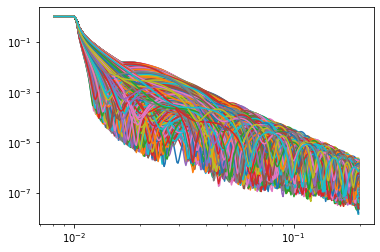

In [18]:
for x in range(curves_nr.shape[0]):
  plt.plot(curves_nr[x][0],curves_nr[x][1])
plt.xscale('log')
plt.yscale('log')

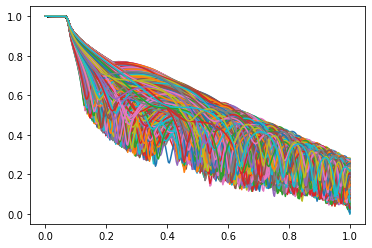

In [19]:
curves_nr = np.log10(curves_nr)

x_points = []
y_points = []
for curve in curves_nr:
    x_points.append(curve[0])
    y_points.append(curve[1])
min_valX = float('inf')
min_valY = float('inf')
max_valX = -float('inf')
max_valY = -float('inf')
for i in range(len(y_points)):
    min_valX = min(min(x_points[i]), min_valX)
    min_valY = min(min(y_points[i]), min_valY)
    max_valX = max(max(x_points[i]), max_valX)
    max_valY = max(max(y_points[i]), max_valY)
for i in range(len(y_points)):
    for j in range(len(y_points[0])):
        x_points[i][j] -= min_valX
        y_points[i][j] -= min_valY
        x_points[i][j] /= (max_valX - min_valX)
        y_points[i][j] /= (max_valY - min_valY)
curves_nr2 = []
for i in range(len(y_points)):
    curves_nr2.append([x_points[i],y_points[i]])
curves_nr2 = np.stack(curves_nr2)
curves_nr2.shape
for x in range(curves_nr.shape[0]):
  plt.plot(curves_nr[x][0],curves_nr[x][1])

[[ 0.00000000e+00  2.59621802e-01  5.19243604e-01 ...  2.32880756e+02
   2.33140378e+02  2.33400000e+02]
 [ 2.07188986e+00  2.07217199e+00  2.07249204e+00 ...  3.24168273e-56
  -1.69018770e-57 -2.82989971e-73]]


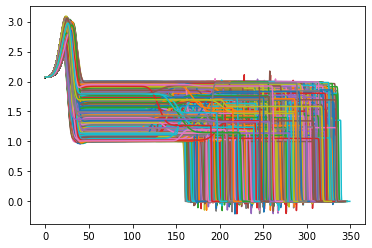

In [20]:
for x in range(curves_nr.shape[0]):
  plt.plot(curves_SLD[x][0],curves_SLD[x][1])
# plt.xscale('log')
# plt.yscale('log')
print(curves_SLD[0])

In [21]:
# # for i in range(curves_SLD.shape[0]):
# #     x_min = min(curves_SLD[i][0])
# #     x_max = max(curves_SLD[i][0])
# #     y_min = min(curves_SLD[i][1])
# #     y_max = max(curves_SLD[i][1])
# #     for j in range(curves_SLD.shape[2]):
# #         curves_SLD[i][0][j] -= x_min
# #         curves_SLD[i][1][j] -= y_min
# #     for j in range(curves_SLD.shape[2]):
# #         curves_SLD[i][0][j] /= (x_max-x_min)
# #         curves_SLD[i][1][j] /= (y_max-y_min)
# x_points = []
# y_points = []
# for curve in curves_SLD:
#     x_points.append(curve[0])
#     y_points.append(curve[1])
# min_valX = float('inf')
# min_valY = float('inf')
# max_valX = -float('inf')
# max_valY = -float('inf')
# for i in range(len(y_points)):
#     min_valX = min(min(x_points[i]), min_valX)
#     min_valY = min(min(y_points[i]), min_valY)
#     max_valX = max(max(x_points[i]), max_valX)
#     max_valY = max(max(y_points[i]), max_valY)
# for i in range(len(y_points)):
#     for j in range(len(y_points[0])):
#         x_points[i][j] -= min_valX
#         y_points[i][j] -= min_valY
#         x_points[i][j] /= (max_valX - min_valX)
#         y_points[i][j] /= (max_valY - min_valY)
# curves_SLD2 = []
# for i in range(30000):
#     curves_SLD2.append([x_points[i],y_points[i]])
# curves_SLD2 = np.stack(curves_SLD2)
# for x in range(curves_nr.shape[0]):
#   plt.plot(curves_SLD[x][0],curves_SLD[x][1])
# # plt.xscale('log')
# # plt.yscale('log')
# print(curves_SLD[0])

In [22]:
class CNN(nn.Module):
    def __init__(self, num_layers):
        super(CNN, self).__init__()
        self.layers = nn.ModuleList()
        addition = 255/num_layers
        curr = 1
        for hdim in range(num_layers-1):
            self.layers.append(nn.Conv1d(int(curr+0.5), int(curr+addition+0.5),51,padding=25))
            self.layers.append(nn.BatchNorm1d(int(curr+addition+0.5)))
            self.layers.append(nn.ReLU(True))
            curr += addition
        self.layers.append(nn.Conv1d(int(curr+0.5), 256, 51, padding=25))
        self.layers.append(nn.BatchNorm1d(256))
        self.layers.append(nn.ReLU(True))
#         self.conv1 = nn.Conv1d(1,13,51,padding=25)
#         self.batch1 = nn.BatchNorm1d(13)
#         self.relu1 = nn.ReLU(True)
        
#         self.conv2 = nn.Conv1d(13,25,51,padding=25)
#         self.batch2 = nn.BatchNorm1d(25)
#         self.relu2 = nn.ReLU(True)
        
#         self.conv3 = nn.Conv1d(25,38,51,padding=25)
#         self.batch3 = nn.BatchNorm1d(38)
#         self.relu3 = nn.ReLU(True)
        
#         self.conv4 = nn.Conv1d(38,50,51,padding=25) 
#         self.batch4 = nn.BatchNorm1d(50)
#         self.relu4 = nn.ReLU(True)
        
#         self.conv5 = nn.Conv1d(50,64,51,padding=25) 
#         self.batch5 = nn.BatchNorm1d(64)
#         self.relu5 = nn.ReLU(True)
        
        self.linear1 = nn.Linear(256*308,900*2)
        # self.linear2 = nn.Linear((256*308-900*2)//2+900*2,900*2)
        # self.linear2 = nn.Linear(120*308,2*308)
        # self.linear2 = nn.Linear(33*308, 2*308)
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        # x = self.batch5(x)
        # x = self.relu5(x)
        # print(x.shape)
        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        # x = self.linear2(x)
        # x = self.linear2(x)
        # x = self.linear2(x)
        x = x.reshape(-1, 2, 900)
        # print(x.shape)
        return x

In [23]:
### Define the loss function
loss_fn = torch.nn.MSELoss()
# class RMSLELoss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.mse = nn.MSELoss()
        
#     def forward(self, pred, actual):
#         return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))
# loss_fn = RMSLELoss()
### Define an optimizer (both for the encoder and the decoder!)
lr= 0.00001

### Set the random seed for reproducible results
torch.manual_seed(0)

#model = Autoencoder(encoded_space_dim=encoded_space_dim)

Model = CNN(num_layers=5)
params_to_optimize = Model.parameters()

optimizer = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cuda


In [24]:
Model.to(device)

RuntimeError: CUDA out of memory. Tried to allocate 542.00 MiB (GPU 0; 39.39 GiB total capacity; 20.51 MiB already allocated; 254.62 MiB free; 34.00 MiB reserved in total by PyTorch)

In [ ]:
## Training function
def fit(Model, dataloader, loss_fn, optim):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    Model.train().to(device)
    train_loss = []
    for data,label in dataloader:
        img = data
        img = img.to(device)
        label = label.to(device)
        decoded_img = Model(img)
        # print(decoded_img.shape)
        # decoded_img = decoded_img.reshape(-1,2, 308)
        loss = loss_fn(decoded_img, label)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss.append(loss.cpu().detach().numpy())
        # print(label, "hello")
    return np.mean(train_loss)

In [ ]:
### Valid function
def val(Model, dataloader, loss_fn):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    Model.eval().to(device)
    with torch.no_grad(): 
        list_decoded_img = []
        list_img = []
        for  data, label in dataloader:
            img = data
            # img = img.view(img.size(0), -1).to(device) 
            # img = img[:,np.newaxis,:].to(device) 
            img = img.to(device) 
            label = label.to(device)
            decoded_img = Model(img)
            # decoded_img = decoded_img.reshape(-1,2, 308)
            list_decoded_img.append(decoded_img.cpu())
            list_img.append(label.cpu())
        list_decoded_img = torch.cat(list_decoded_img)
        list_img = torch.cat(list_img)
        # print(list_img, list_decoded_img, "vaLLLLL FUNCTION")
#         for i in range(len(list_img)):
            
        val_loss = loss_fn(list_decoded_img, list_img)
    return val_loss.data

In [ ]:
def load_data(batch_size, size_split):
    R = curves_nr[:,1]
    R_m = R[:,np.newaxis,:]
    # Q = curves_SLD[:,1]
    # Q_m = Q[:, np.newaxis,:]
    xtrain, ytrain, xval, yval, xtest, ytest = \
    dpre.split_input_arrays(R_m,curves_SLD, size_split=size_split)
    #Prepare data files, continuation
    train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
    dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=batch_size)

    return train_loader, valid_loader, test_loader

In [ ]:
train_loader, valid_loader, test_loader = load_data(32, 0.9)


In [ ]:
def train_cifar(config):
    net = CNN(num_layers=config["num_layers"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    # To restore a checkpoint, use `session.get_checkpoint()`.
    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
           model_state, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

#     data_dir = os.path.abspath("./data")
#     trainset, testset = load_data(data_dir)

#     test_abs = int(len(trainset) * 0.8)
#     train_subset, val_subset = random_split(
#         trainset, [test_abs, len(trainset) - test_abs])

    # trainloader = torch.utils.data.DataLoader(
    #     train_subset,
    #     batch_size=int(config["batch_size"]),
    #     shuffle=True,
    #     num_workers=8)
    # valloader = torch.utils.data.DataLoader(
    #     val_subset,
    #     batch_size=int(config["batch_size"]),
    #     shuffle=True,
    #     num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = fit(net,  train_loader, criterion, optimizer)
        # Validation loss
        val_loss = val(net, valid_loader, criterion)

        # Here we save a checkpoint. It is automatically registered with
        # Ray Tune and can be accessed through `session.get_checkpoint()`
        # API in future iterations.
        os.makedirs("my_model", exist_ok=True)
        torch.save(
            (net.state_dict(), optimizer.state_dict()), "my_model/checkpoint.pt")
        checkpoint = Checkpoint.from_directory("my_model")
        session.report({"loss": (val_loss.item()), "training loss": running_loss}, checkpoint=checkpoint)
    print("Finished Training")

In [ ]:
def test_best_model(best_result):
    best_trained_model = CNN(num_layers=best_result.config["num_layers"])
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")
    
    model_state, optimizer_state = torch.load(checkpoint_path)
    # print(model_state, optimizer_state)
    best_trained_model.load_state_dict(model_state)
    # batch_size=best_result.config["batch_size"]
    # train_loader, valid_loader, test_loader = load_data(batch_size, size_split)
    # trainset, testset = load_data()

#     testloader = torch.utils.data.DataLoader(
#         testset, batch_size=4, shuffle=False, num_workers=2)

    # correct = 0
    # total = 0
    # with torch.no_grad():
    #     for data in testloader:
    #         images, labels = data
    #         images, labels = images.to(device), labels.to(device)
    #         outputs = best_trained_model(images)
    #         _, predicted = torch.max(outputs.data, 1)
    #         total += labels.size(0)
    #         correct += (predicted == labels).sum().item()
    testLoss = val(best_trained_model, test_loader, loss_fn)


    print("Best trial test set accuracy: {}".format(testLoss.item()))

In [ ]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=1):
    config = {
    "lr": tune.loguniform(1e-5, 1e-3), "weight_decay": tune.loguniform(1e-5, 1e-3), "num_layers":tune.choice([7, 8,9,10])
    }
    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_cifar),
            resources={"cpu": 30, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=config,
    )
    results = tuner.fit()
    best_result = results.get_best_result()

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    print("Best trial final training loss: {}".format(
        best_result.metrics["training loss"]))
    test_best_model(best_result)

main(num_samples=70, max_num_epochs=200)

In [ ]:
curves_SLD[0][0][-1]